In [7]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor 

## Todo
- Check out dimension of the data
- Get model architecture of Yann Lecuns paper 
- Train the model



</br>

- Useful Links: 

### Doubts
- How can I add padding to an image? 
- How can I debug a model in PyTorch ? 

### The Architecture
Rebuilding Yann Le Cuns papers: Handwritten Digit Recognitiion with a Back Propagation Network - [1989]

The Model
- 16 * 16 Input Images -> 28 * 28 
- 4 Hidden Layers
    1. Convolutional 1: 4 feature maps with 576 units (24 * 24 feature maps) 5x5 kernel
    2. Pooling: 4 planes of 12*12 -> averaging
    3. Convolutional 2: 12 feature maps (8*8)
    4. Pooling: 12 feature maps, 4*4 plane 
- 10 Unit Output Layer


### Notes
- Having more feature maps in deeper layers allows for more expressiveness in combining the basic features extracted from the first convolutional layers. 
- To create a pooling layer ensuring no overlap, you need to set the stride equal to the kernel size.

### Links
- https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html


In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

6.9%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




29.8%

100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Visualize the data

In [36]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


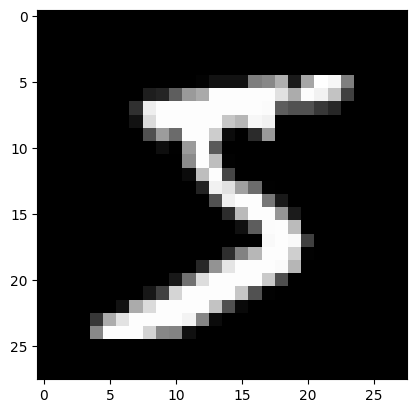

In [37]:
images, labels = next(iter(train_dataloader))

images.shape

plt.imshow(images[0].reshape(28,28), cmap="gray");

In [40]:
torch.cuda.is_available(), torch.backends.mps.is_available()
device = "mps"

In [116]:
16 * 12 / 4

48.0

In [117]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels=4, kernel_size=5, stride=1),
            #nn.ReLU(),
            nn.AvgPool2d(kernel_size=12, stride=12),
            #nn.ReLU(),
            nn.Conv2d(in_channels = 4, out_channels=12, kernel_size=5, stride=1),
            nn.AvgPool2d(kernel_size=4, stride=4),
            nn.Linear(48, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): AvgPool2d(kernel_size=12, stride=12, padding=0)
    (2): Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1))
    (3): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (4): Linear(in_features=48, out_features=10, bias=True)
  )
)


In [118]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [119]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [120]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 784]

3749

2 - two


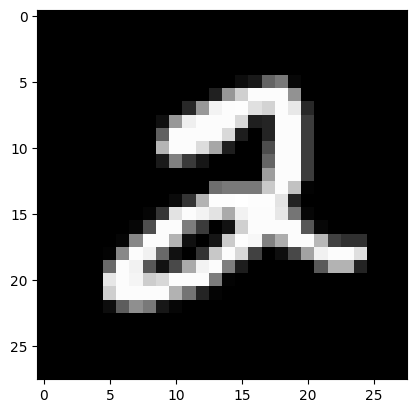

In [107]:
import numpy as np

image_idx = np.random.randint(64)

model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Temporarily turn off gradient descent
    data = images[image_idx].to(device)
    output = model(data)
    _, predicted = torch.max(output.data, 1)

print(training_data.classes[predicted[0].item()])
plt.imshow(images[image_idx].reshape(28,28), cmap="gray");

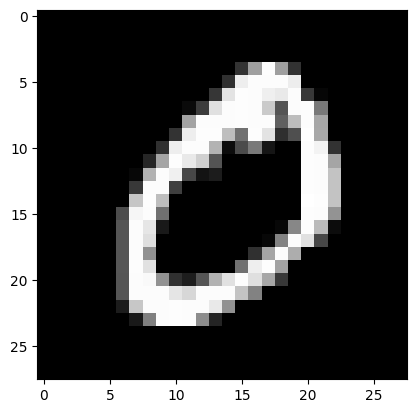